# Potential approach to tranport network analysis

**initialize system** 

* **Step 1:** define nodes and edges of network + vessels in the system (location, origin, destination)

**for each timestep** 

    * shortest distance
    * lowest cost
    * least amount of time
    * lowest CO2 footprint
    * nicest scenery
    * largest loading capacity (no depth restrictions, no height restrictions)
    * fastest sailing speed (vessel speed, current speed)

* **Step 2:** assign weights to edges based on some kind of criterion
    
**NB:** the network can change for each timestep (changing waterlevels, closures, traffic)

    * currents
    * changing waterlevels
    * likely traffic related delays
    * likely infrastructure related delays (locks, bridges)

**for each vessel**

* **Step 3:** For each vessel check the shortest path based on weights assigned

* **Step 4:** For each vessel select its preferred route in case of multiple paths of equal wheight

* **Step 5:** Send vessel on its way for 1 timestep and repeat (sailing speed times timestep is distance)

This procedure will move vessels through the system. Per edge it should be possible to see how many vessels are in it. This will be a matter of postprocessing. I think it should be possible to incorporate such a network weighting routine in a simpy simulation, which could then also simulate queueing. 

Questions:
* what is my best departure time if I want to take the largest amount of cargo?
* which route is most likely to be the fastest
* which will be the busiest parts of the network

## basic imports

In [298]:
# import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## instantiate graph object

In [299]:
# initialise graph object
G = nx.Graph()

## define nodes

In [300]:
# sketch of example graph
#
#  1:       o--o
#          /    \
#  0:  o--o      o--o
#          \    /
# -1:       o--o
#
#      1  2 3  4 5  6

color_map = []
# define and add nodes
G.add_node("a", pos=(1, 0)); color_map.append('r')
G.add_node("b", pos=(2, 0)); color_map.append('r')
G.add_node("c", pos=(3, -1)); color_map.append('r')
G.add_node("d", pos=(3, 1)); color_map.append('r')
G.add_node("e", pos=(4, -1)) ;color_map.append('r')
G.add_node("f", pos=(4, 1)); color_map.append('r')
G.add_node("g", pos=(5, 0)); color_map.append('r')
G.add_node("h", pos=(6, 0));  color_map.append('r')

## define edges

In [301]:
# define wheighted edges (from, to, weight)
e = [("a", "b", 1), 
    ("b", "c", 1), 
    ("b", "d", 2), 
    ("c", "e", 5), 
    ("d", "f", 2), 
    ("e", "g", 1), 
    ("f", "g", 2), 
    ("g", "h", 1)]

# add weighted edges
G.add_weighted_edges_from(e)

## draw graph

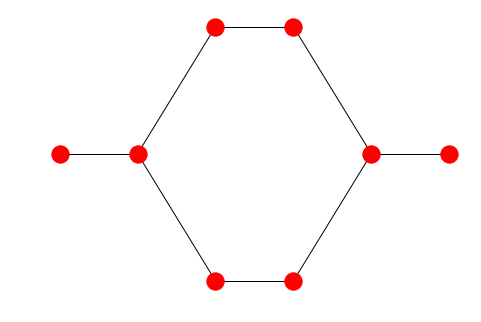

In [302]:
nx.draw(G,nx.get_node_attributes(G, 'pos'))

In [303]:
labels = nx.get_edge_attributes(G,'weight')
print(labels)

{('a', 'b'): 1, ('b', 'c'): 1, ('b', 'd'): 2, ('c', 'e'): 5, ('d', 'f'): 2, ('e', 'g'): 1, ('f', 'g'): 2, ('g', 'h'): 1}


{'a': Text(1,0,'a'),
 'b': Text(2,0,'b'),
 'c': Text(3,-1,'c'),
 'd': Text(3,1,'d'),
 'e': Text(4,-1,'e'),
 'f': Text(4,1,'f'),
 'g': Text(5,0,'g'),
 'h': Text(6,0,'h')}

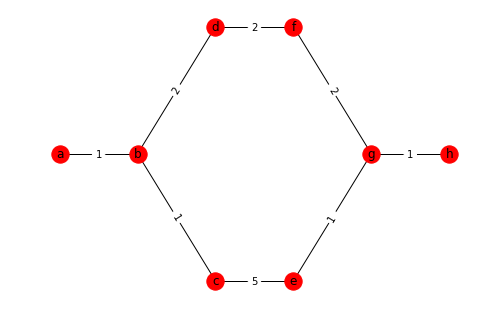

In [304]:
nx.draw(G,nx.get_node_attributes(G, 'pos'))
nx.draw_networkx_edge_labels(G,nx.get_node_attributes(G, 'pos'),edge_labels=labels)
nx.draw_networkx_labels(G,nx.get_node_attributes(G, 'pos'))

In [305]:
color_map


['r', 'r', 'r', 'r', 'r', 'r', 'r', 'r']

## list shortest paths
Shortest path(s) based on weight factors

In [306]:
shortest_path_generator = nx.all_shortest_paths(G, "a", "h", weight="weight")
list(shortest_path_generator)

[['a', 'b', 'd', 'f', 'g', 'h']]

## get Dijkstra path
Shortes path based on weight, but only returns one

In [307]:
path = nx.dijkstra_path(G, "a", "h", weight='weight')
print(path)

['a', 'b', 'd', 'f', 'g', 'h']


## Move a vessel along the Dijkstrapath (starting at path[0])

### create some basic methods for distance, angle, moving, and moving along a path

In [308]:
import math
import networkx as nx

def Distance(Node1, Node2, Print=False):
    # calculate distance between two points
    distance = ((Node2[0]-Node1[0])**2+(Node2[1]-Node1[1])**2)**0.5

    if Print:
        print('distance :', distance)
    return distance

def Angle(Node1, Node2, Print=False):
    # calculate angle going from point 1 to point 2 (NB: atan2(y,x))
    angle = math.atan2(Node2[1]-Node1[1],Node2[0]-Node1[0])*(180.0 / math.pi) 

    if Print:
        print('angle :', angle)
    return angle

def Move(Node1, Node2, move, Print=False):
    # move towards Node2
    distance = Distance(Node1, Node2)
    angle = Angle(Node1, Node2)
    new_node = (Node1[0]+math.cos(angle*math.pi/180)*move, Node1[1]+math.sin(angle*math.pi/180)*move)
    if Print:
        print('new_node :', new_node)
    return new_node

def Move_on_path(G, vessel_pos, path, to_node_id, move, Print=False):
    # 1. vessel_pos is your boat
    # 2. you need to know the next node in the path
    # 3. calculate the distance between Node1 and the next node
    to_node_pos = nx.get_node_attributes(G, 'pos')[path[to_node_id]]
    distance_to_next_node = Distance(vessel_pos, to_node_pos, True)
    print('distance_to_next_node: ', distance_to_next_node)
    
    # If move <= distance to next node, make move
    if move < distance_to_next_node:
            print('move: ', move)
            vessel_pos_new = Move(vessel_pos, to_node_pos, move, True)
    else:
        if to_node_id == len(path)-1:
            print('arrived')
            vessel_pos_new = to_node_pos 
        else:
            # reposition vessel at next node and calculate remaining move distance
            vessel_pos = nx.get_node_attributes(G, 'pos')[path[to_node_id]]
            # up the to_node_id with 1 and find new to_node_pos
            to_node_id+=1
            to_node_pos = nx.get_node_attributes(G, 'pos')[path[to_node_id]]
            # calculate distance to next node
            print('move: ', move)
            move = move-distance_to_next_node
            print('move: ', move)
            vessel_pos_new = Move(vessel_pos, to_node_pos, move, True)
        
    # If move > distance to next node, move to next node and set move to move-distance, try again
    if Print:
        print('vessel_pos_new:', vessel_pos_new)
        print('to_node_id :', to_node_id)
        print('')
        
    return vessel_pos_new, to_node_id

## Initiate the move

In [309]:
# get the Dijkstra path a few cells up
# path = ['a', 'b', 'd', 'f', 'g', 'h'] 
time = 0
timestep = 1

# start to move at path[0]
vessel_pos = nx.get_node_attributes(G, 'pos')[path[0]] 
G.add_node(timestep, pos=vessel_pos)
color_map.append('b')

# we need to keep track of the to_node_id
to_node_id = 1 

## run this cell with cntrl+enter until the vessel arrives

In [310]:
while to_node_id<len(path)-1:
    # run this cell with cntrl+enter, or in a while loop to take timesteps
    # termine move
    time = time + timestep
    speed = 0.5
    move = timestep * speed

    vessel_pos, to_node_id = Move_on_path(G, vessel_pos, path, to_node_id, move, True)
    G.add_node(time, pos=vessel_pos)
    color_map.append('b')

time = time + timestep
speed = 0.5
move = timestep * speed

vessel_pos, to_node_id = Move_on_path(G, vessel_pos, path, to_node_id, move, True)
G.add_node(time, pos=vessel_pos)
color_map.append('b')


time = time + timestep
speed = 0.5
move = timestep * speed

vessel_pos, to_node_id = Move_on_path(G, vessel_pos, path, to_node_id, move, True)
G.add_node(time, pos=vessel_pos)
color_map.append('b')


distance : 1.0
distance_to_next_node:  1.0
move:  0.5
new_node : (1.5, 0.0)
vessel_pos_new: (1.5, 0.0)
to_node_id : 1

distance : 0.5
distance_to_next_node:  0.5
move:  0.5
move:  0.0
new_node : (2.0, 0.0)
vessel_pos_new: (2.0, 0.0)
to_node_id : 2

distance : 1.4142135623730951
distance_to_next_node:  1.4142135623730951
move:  0.5
new_node : (2.353553390593274, 0.3535533905932738)
vessel_pos_new: (2.353553390593274, 0.3535533905932738)
to_node_id : 2

distance : 0.9142135623730949
distance_to_next_node:  0.9142135623730949
move:  0.5
new_node : (2.7071067811865475, 0.7071067811865477)
vessel_pos_new: (2.7071067811865475, 0.7071067811865477)
to_node_id : 2

distance : 0.414213562373095
distance_to_next_node:  0.414213562373095
move:  0.5
move:  0.08578643762690502
new_node : (3.085786437626905, 1.0)
vessel_pos_new: (3.085786437626905, 1.0)
to_node_id : 3

distance : 0.9142135623730949
distance_to_next_node:  0.9142135623730949
move:  0.5
new_node : (3.585786437626905, 1.0)
vessel_pos_ne

In [311]:
nx.get_node_attributes(G, 'node_color')
nx.get_node_attributes(G, 'pos')

{1: (1.5, 0.0),
 10: (5.17157287525381, 0.0),
 11: (5.67157287525381, 0.0),
 12: (6, 0),
 2: (2.0, 0.0),
 3: (2.353553390593274, 0.3535533905932738),
 4: (2.7071067811865475, 0.7071067811865477),
 5: (3.085786437626905, 1.0),
 6: (3.585786437626905, 1.0),
 7: (4.060660171779821, 0.9393398282201786),
 8: (4.414213562373095, 0.585786437626905),
 9: (4.767766952966369, 0.23223304703363123),
 'a': (1, 0),
 'b': (2, 0),
 'c': (3, -1),
 'd': (3, 1),
 'e': (4, -1),
 'f': (4, 1),
 'g': (5, 0),
 'h': (6, 0)}

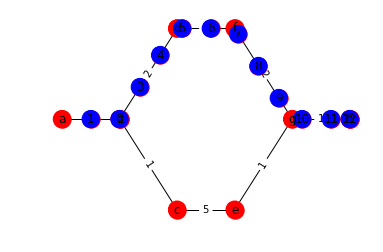

<Figure size 432x288 with 0 Axes>

In [312]:
fig = plt.figure                                    
ax = plt.subplot(111)                               

nx.draw(G,nx.get_node_attributes(G, 'pos'))
nx.draw_networkx_edge_labels(G,nx.get_node_attributes(G, 'pos'),edge_labels=labels)
nx.draw_networkx_labels(G,nx.get_node_attributes(G, 'pos'))
nx.draw_networkx_nodes(G,nx.get_node_attributes(G, 'pos'),node_color=color_map)

plt.show()
plt.savefig('test.png')


### Brief tests of the above methods to check if they work

In [167]:
Node1=(0,0);Node2=(1,0);Angle(Node1,Node2, True)
Node1=(0,0);Node2=(1,1);Angle(Node1,Node2, True)
Node1=(0,0);Node2=(0,1);Angle(Node1,Node2, True)
Node1=(0,0);Node2=(-1,1);Angle(Node1,Node2, True)
Node1=(0,0);Node2=(-1,0);Angle(Node1,Node2, True)
Node1=(0,0);Node2=(-1,-1);Angle(Node1,Node2, True)
Node1=(0,0);Node2=(0,-1);Angle(Node1,Node2, True)
Node1=(0,0);Node2=(1,-1);Angle(Node1,Node2, True)

Node1=(0,0);Node2=(2,0);Angle(Node1,Node2,True)
Node1=(0,0);Node2=(2,2);Angle(Node1,Node2, True);Move(Node1,Node2,1, True)
Node1=(0,0);Node2=(0,2);Angle(Node1,Node2, True)
Node1=(0,0);Node2=(-2,2);Angle(Node1,Node2, True)
Node1=(0,0);Node2=(-2,0);Angle(Node1,Node2, True)
Node1=(0,0);Node2=(-2,-2);Angle(Node1,Node2, True);Move(Node1,Node2,1, True)
Node1=(0,0);Node2=(0,-2);Angle(Node1,Node2, True)
Node1=(0,0);Node2=(2,-2);Angle(Node1,Node2, True)


angle : 0.0
angle : 45.0
angle : 90.0
angle : 135.0
angle : 180.0
angle : -135.0
angle : -90.0
angle : -45.0
angle : 0.0
angle : 45.0
new_node : (0.7071067811865476, 0.7071067811865476)
angle : 90.0
angle : 135.0
angle : 180.0
angle : -135.0
new_node : (-0.7071067811865475, -0.7071067811865476)
angle : -90.0
angle : -45.0


-45.0

# Waterlevel on a river

## Basic code

In [ ]:
import numpy as np

def get_values_from_node(F, prop):
    """extract info from nodes"""
    values=[]
    for key, value in F.nodes(prop):
        values = np.append(values, value)

    return values

def get_min_depth(F):
    """extract bed and waterlvl info from nodes and 
    find the minimum depth"""
    bed = get_values_from_node(F, 'bed')
    waterlvl = get_values_from_node(F, 'waterlvl')
    depth = waterlvl-bed

    return np.min(depth)

## nodes

In [ ]:
# initialise grid (100 km in steps of 10 km)
x = range(0, 100000, 10000)

In [ ]:
# initialise graph object
F = nx.Graph()

In [ ]:
# add nodes with bed and waterlevels
bed = -5
waterlvl = 0
for val in x:
    F.add_node("x=" + str(val), pos=(val, 0), bed=bed, waterlvl=waterlvl)
    bed = bed + 0.5
    waterlvl = waterlvl + 0.5 + np.sin(val* np.pi*10E8) 

In [ ]:
nx.draw(F,nx.get_node_attributes(F, 'pos'))
labels = nx.get_edge_attributes(F,'weight')
nx.draw_networkx_edge_labels(F,nx.get_node_attributes(F, 'pos'),edge_labels=labels)
nx.draw_networkx_labels(F,nx.get_node_attributes(F, 'pos'));

In [ ]:
min_depth = get_min_depth(F)
min_depth